In [40]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from functools import reduce
from scipy.stats import mode

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb

pd.set_option('display.max_columns', None)

In [2]:
data_training = pd.read_csv('cybersecurity_training.csv', delimiter='|')
data_test = pd.read_csv('cybersecurity_test.csv', delimiter='|')
data_alerts = pd.read_csv('localized_alerts_data.csv', delimiter='|')

C:\Users\zuzanna.deska\AppData\Local\Temp\ipykernel_2876\1816288404.py:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data_alerts = pd.read_csv('localized_alerts_data.csv', delimiter='|')


In [3]:
df_training = pd.DataFrame(data_training)
df_test = pd.DataFrame(data_test)
df_alerts = pd.DataFrame(data_alerts)

In [4]:
df_alerts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8690704 entries, 0 to 8690703
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   alert_ids             object 
 1   alerttype             object 
 2   devicetype            object 
 3   reportingdevice_code  object 
 4   devicevendor_code     object 
 5   srcip                 object 
 6   dstip                 object 
 7   srcipcategory         object 
 8   dstipcategory         object 
 9   srcport               float64
 10  dstport               float64
 11  srcportcategory       int64  
 12  dstportcategory       int64  
 13  direction             int64  
 14  alerttime             int64  
 15  severity              int64  
 16  count                 int64  
 17  domain                int64  
 18  protocol              object 
 19  username              int64  
 20  signature             int64  
dtypes: float64(2), int64(9), object(10)
memory usage: 1.4+ GB


In [5]:
cat_string_columns = ['categoryname', 'ipcategory_name', 'ipcategory_scope', 'parent_category', 'grandparent_category', 'weekday', 'dstipcategory_dominate', 'srcipcategory_dominate']
cat_numeric_columns = ['overallseverity', 'start_hour', 'start_minute', 'start_second', 'score', 'alerttype_cd', 'direction_cd', 'eventname_cd', 'isiptrusted', 'dstportcategory_dominate', 'srcportcategory_dominate', 'p6', 'p5m', 'p5w', 'p5d', 'p8m', 'p8w', 'p8d']
bin_columns = ['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10']

In [6]:
def get_ip_zone(ip_address, id_zone):
    return ip_address.split(".")[id_zone - 1]

def get_duration(timestamp):
    return timestamp // 3600

def get_sum(scores):
    return sum(scores)

def concat_values(vals):
    return "-".join([str(val) for val in vals])

def get_ip(ip_address):
    return np.nan if isinstance(ip_address, float) and np.isnan(ip_address) else str(ip_address).split(".")[0]

In [7]:
# TRAINING file and TEST file

# fill NaN
for column in bin_columns:
    print(f"Fill NaN values {column}")
    df_training[column].fillna(-1, inplace=True)
    df_test[column].fillna(-1, inplace=True)

print(f"Fill NaN values Score")
df_training['score'].fillna(-1, inplace=True)
df_test['score'].fillna(-1, inplace=True)

# processing features

# IP ZONE for training file
df_training["ip_zone_1"] = df_training.apply(lambda row: get_ip_zone(row["ip"], 1), axis=1)
df_training["ip_zone_2"] = df_training.apply(lambda row: get_ip_zone(row["ip"], 2), axis=1)
df_training["ip_zone_3"] = df_training.apply(lambda row: get_ip_zone(row["ip"], 3), axis=1)
df_training["ip_zone_4"] = df_training.apply(lambda row: get_ip_zone(row["ip"], 4), axis=1)

df_training["ip_zone_12"] = df_training.apply(lambda row: concat_values([row["ip_zone_1"], row["ip_zone_2"]]), axis = 1)
df_training["ip_zone_123"] = df_training.apply(lambda row: concat_values([row["ip_zone_1"], row["ip_zone_2"], row["ip_zone_3"]]), axis = 1)

# IP ZONE for test file
df_test["ip_zone_1"] = df_test.apply(lambda row: get_ip_zone(row["ip"], 1), axis=1)
df_test["ip_zone_2"] = df_test.apply(lambda row: get_ip_zone(row["ip"], 2), axis=1)
df_test["ip_zone_3"] = df_test.apply(lambda row: get_ip_zone(row["ip"], 3), axis=1)
df_test["ip_zone_4"] = df_test.apply(lambda row: get_ip_zone(row["ip"], 4), axis=1)

df_test["ip_zone_12"] = df_test.apply(lambda row: concat_values([row["ip_zone_1"], row["ip_zone_2"]]), axis = 1)
df_test["ip_zone_123"] = df_test.apply(lambda row: concat_values([row["ip_zone_1"], row["ip_zone_2"], row["ip_zone_3"]]), axis = 1)

# timestamp to duration in hours for TRAINING and TEST files
df_training["timestamp_hour"] = df_training.apply(lambda row: get_duration(row["timestamp_dist"]), axis = 1)
df_test["timestamp_hour"] = df_test.apply(lambda row: get_duration(row["timestamp_dist"]), axis = 1)

# sum queries
df_training["sum_n_queries"] = df_training.apply(lambda row: get_sum([row["n{}".format(i)] for i in range(1, 11)]), axis = 1)
df_training["sum_p5"] = df_training.apply(lambda row: get_sum([row["p5{}".format(p5)] for p5 in ["m", "w", "d"]]), axis = 1)
df_training["sum_p8"] = df_training.apply(lambda row: get_sum([row["p8{}".format(p8)] for p8 in ["m", "w", "d"]]), axis = 1)

df_test["sum_n_queries"] = df_test.apply(lambda row: get_sum([row["n{}".format(i)] for i in range(1, 11)]), axis = 1)
df_test["sum_p5"] = df_test.apply(lambda row: get_sum([row["p5{}".format(p5)] for p5 in ["m", "w", "d"]]), axis = 1)
df_test["sum_p8"] = df_test.apply(lambda row: get_sum([row["p8{}".format(p8)] for p8 in ["m", "w", "d"]]), axis = 1)


Fill NaN values n1
Fill NaN values n2
Fill NaN values n3
Fill NaN values n4
Fill NaN values n5
Fill NaN values n6
Fill NaN values n7
Fill NaN values n8
Fill NaN values n9
Fill NaN values n10
Fill NaN values Score


In [49]:
label_encoder = LabelEncoder()

def encode(df, columns, le):
    for column in columns:
        print("Label encoding {}".format(column))
        label_encoder.fit(df[column])
        df[column] = label_encoder.transform(df[column])


# encode features with label encoder on training file
encode(df_training, cat_string_columns, label_encoder)
    
# encode features with label encoder on test file
encode(df_test, cat_string_columns, label_encoder)

Label encoding categoryname
Label encoding ipcategory_name
Label encoding ipcategory_scope
Label encoding parent_category
Label encoding grandparent_category
Label encoding weekday
Label encoding dstipcategory_dominate
Label encoding srcipcategory_dominate
Label encoding categoryname
Label encoding ipcategory_name
Label encoding ipcategory_scope
Label encoding parent_category
Label encoding grandparent_category
Label encoding weekday
Label encoding dstipcategory_dominate
Label encoding srcipcategory_dominate


In [9]:
col_to_drop = ['ip', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 
               'n8', 'n9', 'n10', 'p6', 'p9', 'p5m', 'p5w', 
               'p5d','p8m', 'p8w', 'p8d', 'timestamp_dist']

In [10]:
df_training = df_training.drop(col_to_drop, axis=1)
df_test = df_test.drop(col_to_drop, axis=1)

In [11]:
# alerts file
df_alerts['srcip'] = df_alerts.apply(lambda row: get_ip(row['srcip']), axis=1)
df_alerts['dstip'] = df_alerts.apply(lambda row: get_ip(row['dstip']), axis=1)

df_alerts['protocol'] = df_alerts['protocol'].apply(str)

In [12]:
# 'grouping by' in alerts file

df_alerts_alerttime = df_alerts[['alert_ids', 'alerttime']].groupby('alert_ids', as_index=False).max()
df_alerts_alerttime_mean = df_alerts[['alert_ids', 'alerttime']].groupby('alert_ids', as_index=False).mean().rename(columns={'alerttime': 'alerttime_mean'})

df_alerts_severity_mean = df_alerts[['alert_ids', 'severity']].groupby('alert_ids', as_index=False).mean().rename(columns={'severity': 'severity_mean'})
df_alerts_severity_max = df_alerts[['alert_ids', 'severity']].groupby('alert_ids', as_index=False).max().rename(columns={'severity': 'severity_max'})
df_alerts_severity_min = df_alerts[['alert_ids', 'severity']].groupby('alert_ids', as_index=False).min().rename(columns={'severity': 'severity_min'})

df_alerts_count = df_alerts[['alert_ids', 'count']].groupby('alert_ids', as_index=False).sum()
df_alerts_count_mean = df_alerts[['alert_ids', 'count']].groupby('alert_ids', as_index=False).mean().rename(columns={'count': 'count_mean'})

df_alerts_domain_mean = df_alerts[['alert_ids', 'domain']].groupby('alert_ids', as_index=False).mean().rename(columns={'domain': 'domain_mean'})

df_alerts_signature_mean = df_alerts[['alert_ids', 'signature']].groupby('alert_ids', as_index=False).mean().rename(columns={'signature': 'signature_mean'})

df_alerts_direction_mean = df_alerts[['alert_ids', 'direction']].groupby('alert_ids', as_index=False).mean().rename(columns={'direction': 'direction_mean'})

In [13]:
merge_df = [df_alerts_alerttime, df_alerts_alerttime_mean, df_alerts_severity_mean, 
            df_alerts_severity_max, df_alerts_severity_min, df_alerts_count, df_alerts_count_mean, 
            df_alerts_domain_mean, df_alerts_signature_mean, df_alerts_direction_mean]

def merge_data(left, right):
    return pd.merge(left, right, on='alert_ids', how='left')

merged_df = reduce(merge_data, merge_df)

In [17]:
scaler = MinMaxScaler()
df_scale = merged_df[['alerttime', 'alerttime_mean', 'severity_mean', 'count', 'count_mean', 'domain_mean', 'signature_mean', 'direction_mean']]
# fit and transform the data
df_scaled = pd.DataFrame(scaler.fit_transform(df_scale), columns=df_scale.columns)

In [19]:
merged_df.update(df_scaled)

In [20]:
df_training = df_training.merge(merged_df, left_on='alert_ids', right_on='alert_ids')
df_test = df_test.merge(merged_df, left_on='alert_ids', right_on='alert_ids')

In [21]:
def get_port_range(port):
    for port_range, port_label in port_ranges.items():
        if port_range[0] <= port <= port_range[1]:
            return port_label
    return 'Unknown'

In [22]:
port_ranges = {
    (0, 1023): 'WKP',
    (1024, 49151): 'RP',
    (49152, 65535): 'D/PP',
}

In [23]:
df_alerts['srcport_range'] = df_alerts['srcport'].apply(get_port_range)
df_alerts['dstport_range'] = df_alerts['dstport'].apply(get_port_range)

In [24]:
def get_mode(column_name):
    df_alerts_grouped = df_alerts.groupby('alert_ids')[col].apply(lambda row: mode(row, axis=None, keepdims=True).mode[0]).reset_index()
    df_alerts_grouped.rename(columns={col: f'{col}_list'}, inplace=True)
    return df_alerts_grouped

In [25]:
col_to_mode = ['protocol', 'alerttype', 'devicetype', 'reportingdevice_code', 
           'devicevendor_code', 'srcportcategory', 'dstportcategory', 
           'username',  'srcipcategory', 'dstipcategory', 'srcip', 'dstip', 'srcport_range', 'dstport_range']

for col in col_to_mode:
    df_training = df_training.merge(get_mode(col), left_on='alert_ids', right_on='alert_ids')
    df_test = df_test.merge(get_mode(col), left_on='alert_ids', right_on='alert_ids')

C:\Users\zuzanna.deska\AppData\Local\Temp\ipykernel_2876\38064324.py:2: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  df_alerts_grouped = df_alerts.groupby('alert_ids')[col].apply(lambda row: mode(row, axis=None, keepdims=True).mode[0]).reset_index()
C:\Users\zuzanna.deska\AppData\Local\Temp\ipykernel_2876\38064324.py:2: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  df_alerts_grouped = df_alerts.groupby('alert_ids')[col].apply(lambda row: mode(row, axis=None, keepdims=True).mode[0]).reset_index()
C:\Users\zuzanna.deska\AppData\Local\Temp\ipykernel_2876\38064324.py:2: DeprecationWarning: Support fo

C:\Users\zuzanna.deska\AppData\Local\Temp\ipykernel_2876\38064324.py:2: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  df_alerts_grouped = df_alerts.groupby('alert_ids')[col].apply(lambda row: mode(row, axis=None, keepdims=True).mode[0]).reset_index()
C:\Users\zuzanna.deska\AppData\Local\Temp\ipykernel_2876\38064324.py:2: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  df_alerts_grouped = df_alerts.groupby('alert_ids')[col].apply(lambda row: mode(row, axis=None, keepdims=True).mode[0]).reset_index()
C:\Users\zuzanna.deska\AppData\Local\Temp\ipykernel_2876\38064324.py:2: DeprecationWarning: Support fo

In [26]:
def map_protocol_category(value):
    value = str(value).lower()

    if value in ['6', 'tcp']:
        return 'TCP'
    elif value in ['17', 'udp']:
        return 'UDP'
    elif 'http' in value or 'https' in value:
        return 'HTTP/HTTPS'
    elif 'dns' in value:
        return 'DNS'
    elif 'smtp' in value:
        return 'SMTP'
    elif 'ntp' in value:
        return 'NTP'
    else:
        return 'Other'

In [27]:
df_training['protocol_list'] = df_training['protocol_list'].map(map_protocol_category)
df_test['protocol_list'] = df_test['protocol_list'].map(map_protocol_category)

In [29]:
pd.set_option('display.max_rows', 80)
print(df_test.isna().sum())

alert_ids                       0
client_code                     0
categoryname                    0
ipcategory_name                 0
ipcategory_scope                0
parent_category                 0
grandparent_category            0
overallseverity                 0
start_hour                      0
start_minute                    0
start_second                    0
weekday                         0
correlatedcount                 0
score                           0
srcip_cd                        0
dstip_cd                        0
srcport_cd                      0
dstport_cd                      0
alerttype_cd                    0
direction_cd                    0
eventname_cd                    0
severity_cd                     0
reportingdevice_cd              0
devicetype_cd                   0
devicevendor_cd                 0
domain_cd                       0
protocol_cd                     0
username_cd                     0
srcipcategory_cd                0
dstipcategory_

In [30]:
pd.set_option('display.max_rows', 80)
print(df_training.isna().sum())

alert_ids                       0
client_code                     0
notified                        0
categoryname                    0
ipcategory_name                 0
ipcategory_scope                0
parent_category                 0
grandparent_category            0
overallseverity                 0
start_hour                      0
start_minute                    0
start_second                    0
weekday                         0
correlatedcount                 0
score                           0
srcip_cd                        0
dstip_cd                        0
srcport_cd                      0
dstport_cd                      0
alerttype_cd                    0
direction_cd                    0
eventname_cd                    0
severity_cd                     0
reportingdevice_cd              0
devicetype_cd                   0
devicevendor_cd                 0
domain_cd                       0
protocol_cd                     0
username_cd                     0
srcipcategory_

In [31]:
df_training['devicetype_list'].fillna(df_training['devicetype_list'].mode()[0], inplace=True)
df_training['reportingdevice_code_list'].fillna(df_training['reportingdevice_code_list'].mode()[0], inplace=True)
df_training['devicevendor_code_list'].fillna(df_training['devicevendor_code_list'].mode()[0], inplace=True)
df_training['dstip_list'].fillna(df_training['dstip_list'].mode()[0], inplace=True)
df_training['srcip_list'].fillna(df_training['srcip_list'].mode()[0], inplace=True)

df_test['devicetype_list'].fillna(df_test['devicevendor_code_list'].mode()[0], inplace=True)
df_test['reportingdevice_code_list'].fillna(df_test['devicevendor_code_list'].mode()[0], inplace=True)
df_test['devicevendor_code_list'].fillna(df_test['dstip_list'].mode()[0], inplace=True)
df_test['dstip_list'].fillna(df_test['srcip_list'].mode()[0], inplace=True)

In [33]:
df_training = df_training.drop(['alert_ids', 'client_code'], axis=1)

df_test = df_test.drop(['alert_ids', 'client_code'], axis=1)

In [34]:
df_training = df_training.drop(['ip_zone_1', 'ip_zone_2', 'ip_zone_3', 'ip_zone_4'], axis=1)

df_test = df_test.drop(['ip_zone_1', 'ip_zone_2', 'ip_zone_3', 'ip_zone_4'], axis=1)

In [45]:
col_to_encode = ['ip_zone_12', 'ip_zone_123', 'protocol_list', 'alerttype_list', 'devicetype_list', 
                 'reportingdevice_code_list', 'devicevendor_code_list', 'srcipcategory_list', 'dstipcategory_list',
                'srcip_list', 'dstip_list', 'srcport_range_list', 'dstport_range_list']

In [50]:
# encode rest features with label encoder
encode(df_training, col_to_encode, label_encoder)
    
# encode features with label encoder on test file
encode(df_test, col_to_encode, label_encoder)

Label encoding ip_zone_12
Label encoding ip_zone_123
Label encoding protocol_list
Label encoding alerttype_list
Label encoding devicetype_list
Label encoding reportingdevice_code_list
Label encoding devicevendor_code_list
Label encoding srcipcategory_list
Label encoding dstipcategory_list
Label encoding srcip_list
Label encoding dstip_list
Label encoding srcport_range_list
Label encoding dstport_range_list
Label encoding ip_zone_12
Label encoding ip_zone_123
Label encoding protocol_list
Label encoding alerttype_list
Label encoding devicetype_list
Label encoding reportingdevice_code_list
Label encoding devicevendor_code_list
Label encoding srcipcategory_list
Label encoding dstipcategory_list
Label encoding srcip_list
Label encoding dstip_list
Label encoding srcport_range_list
Label encoding dstport_range_list


#### Feature selection

In [55]:
ready_df = df_training.drop(columns='notified')
df_class = df_training[['notified']]

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(ready_df, df_class, stratify=df_class, random_state=42)

In [63]:
feature_names = ready_df.columns
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train_f, y_train_f.values.ravel())

RandomForestClassifier(random_state=0)

In [58]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

Most important features:
thrcnt_month: 0.04453453627818701
thrcnt_week: 0.04317441872314787
dstip_list: 0.04066801654579847
ip_zone_123: 0.040120854904372984
ip_zone_12: 0.040026200944762357
thrcnt_day: 0.03585998770684729
reportingdevice_code_list: 0.03581452127003687
count_mean: 0.03224126274244511
start_minute: 0.030873291858010448
start_second: 0.030362153586681984
correlatedcount: 0.030094794105262637
start_hour: 0.029037244653602075
alerttype_list: 0.027091013630350283
count: 0.02681485994233819
alerttime_mean: 0.026652894648733907
alerttime: 0.026452227724201083
severity_mean: 0.024690605755090717
categoryname: 0.021537996333221527
protocol_list: 0.021271648016464723
srcip_list: 0.020788861820650532
devicevendor_code_list: 0.020489638420575065
weekday: 0.019927567187898256
timestamp_hour: 0.017542134077396437
direction_mean: 0.016719411137951484
sum_p8: 0.014868265793198597
sum_p5: 0.014550842850055859
flowscore: 0.01279101751449544
signature_mean: 0.012245101362972192
srcipcate

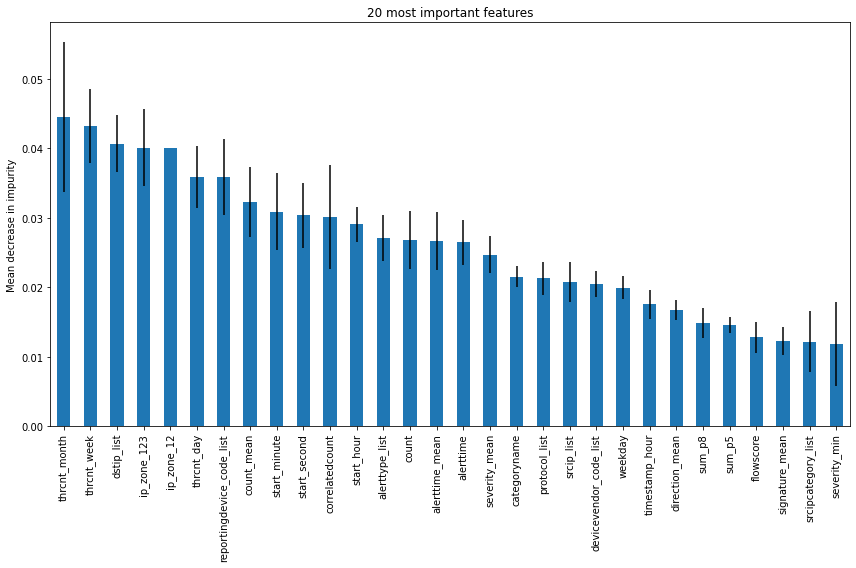

In [59]:
top_features = forest_importances.sort_values(ascending=False)[:30]


fig, ax = plt.subplots(figsize=(12, 8))
top_features.plot(kind='bar', yerr=std[top_features.index.get_indexer_for(top_features.index)], ax=ax)
ax.set_title("20 most important features")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

print("Most important features:")
for feature, importance in top_features.items():
    print(f"{feature}: {importance}")

#### Modeling

In [60]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(ready_df, df_class, stratify=df_class, random_state=42)

# scale_pos_weight manage unbalanced dataset
# models parameters
params = {
    'colsample_bytree': 1.0, 
    'gamma': 1.5,
    'booster': 'dart',
    'eta': 0.02,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'min_child_weight': 1,
    'gamma': 5,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'max_depth': 5,
    'scale_pos_weight': 16.32
}

# XGBoost model object
model = xgb.train(params, 
                  dtrain=xgb.DMatrix(X_train, label=y_train),
                  num_boost_round=500,
                  early_stopping_rounds=250,
                  evals=[(xgb.DMatrix(X_train, label=y_train), 'train'), (xgb.DMatrix(X_test, label=y_test), 'test')],
                  verbose_eval=True)

# prediction
y_pred = model.predict(xgb.DMatrix(X_test))


roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {roc_auc}")

[0]	train-auc:0.82015	test-auc:0.79040
[1]	train-auc:0.85610	test-auc:0.83032
[2]	train-auc:0.87351	test-auc:0.85185
[3]	train-auc:0.88722	test-auc:0.86290
[4]	train-auc:0.89030	test-auc:0.86704
[5]	train-auc:0.89246	test-auc:0.86961
[6]	train-auc:0.89270	test-auc:0.87110
[7]	train-auc:0.89377	test-auc:0.87125
[8]	train-auc:0.89475	test-auc:0.87152
[9]	train-auc:0.89545	test-auc:0.87227
[10]	train-auc:0.89622	test-auc:0.87334
[11]	train-auc:0.89584	test-auc:0.87336
[12]	train-auc:0.89699	test-auc:0.87453
[13]	train-auc:0.89787	test-auc:0.87533
[14]	train-auc:0.89902	test-auc:0.87591
[15]	train-auc:0.89913	test-auc:0.87571
[16]	train-auc:0.90033	test-auc:0.87596
[17]	train-auc:0.90052	test-auc:0.87694
[18]	train-auc:0.90117	test-auc:0.87814
[19]	train-auc:0.90165	test-auc:0.87913
[20]	train-auc:0.90121	test-auc:0.87886
[21]	train-auc:0.90153	test-auc:0.87928
[22]	train-auc:0.90223	test-auc:0.87991
[23]	train-auc:0.90236	test-auc:0.87997
[24]	train-auc:0.90300	test-auc:0.88018
[25]	train

[203]	train-auc:0.94092	test-auc:0.90665
[204]	train-auc:0.94108	test-auc:0.90671
[205]	train-auc:0.94131	test-auc:0.90696
[206]	train-auc:0.94139	test-auc:0.90698
[207]	train-auc:0.94165	test-auc:0.90720
[208]	train-auc:0.94187	test-auc:0.90738
[209]	train-auc:0.94194	test-auc:0.90736
[210]	train-auc:0.94206	test-auc:0.90739
[211]	train-auc:0.94227	test-auc:0.90757
[212]	train-auc:0.94239	test-auc:0.90768
[213]	train-auc:0.94263	test-auc:0.90779
[214]	train-auc:0.94287	test-auc:0.90809
[215]	train-auc:0.94298	test-auc:0.90827
[216]	train-auc:0.94312	test-auc:0.90834
[217]	train-auc:0.94332	test-auc:0.90850
[218]	train-auc:0.94345	test-auc:0.90864
[219]	train-auc:0.94354	test-auc:0.90869
[220]	train-auc:0.94373	test-auc:0.90884
[221]	train-auc:0.94387	test-auc:0.90888
[222]	train-auc:0.94410	test-auc:0.90906
[223]	train-auc:0.94449	test-auc:0.90926
[224]	train-auc:0.94474	test-auc:0.90954
[225]	train-auc:0.94511	test-auc:0.90969
[226]	train-auc:0.94520	test-auc:0.90973
[227]	train-auc:

[403]	train-auc:0.96527	test-auc:0.92253
[404]	train-auc:0.96537	test-auc:0.92261
[405]	train-auc:0.96543	test-auc:0.92257
[406]	train-auc:0.96548	test-auc:0.92262
[407]	train-auc:0.96565	test-auc:0.92269
[408]	train-auc:0.96570	test-auc:0.92269
[409]	train-auc:0.96580	test-auc:0.92269
[410]	train-auc:0.96593	test-auc:0.92282
[411]	train-auc:0.96598	test-auc:0.92281
[412]	train-auc:0.96614	test-auc:0.92286
[413]	train-auc:0.96618	test-auc:0.92290
[414]	train-auc:0.96623	test-auc:0.92292
[415]	train-auc:0.96628	test-auc:0.92296
[416]	train-auc:0.96631	test-auc:0.92294
[417]	train-auc:0.96634	test-auc:0.92297
[418]	train-auc:0.96643	test-auc:0.92295
[419]	train-auc:0.96658	test-auc:0.92296
[420]	train-auc:0.96659	test-auc:0.92294
[421]	train-auc:0.96668	test-auc:0.92291
[422]	train-auc:0.96681	test-auc:0.92297
[423]	train-auc:0.96695	test-auc:0.92298
[424]	train-auc:0.96705	test-auc:0.92301
[425]	train-auc:0.96713	test-auc:0.92302
[426]	train-auc:0.96722	test-auc:0.92307
[427]	train-auc:

#### Modeling with feature selection

In [61]:
df_train_selected = df_training.drop(columns='notified')
df_class = df_training[['notified']]
cols_to_train = ['thrcnt_month', 'thrcnt_week', 'dstip_list', 'ip_zone_123', 'ip_zone_12', 'thrcnt_day',
                 'reportingdevice_code_list', 'count_mean', 'start_minute', 'start_second',
                 'correlatedcount', 'start_hour', 'alerttype_list', 'count', 'alerttime_mean', 'alerttime', 'severity_mean',
                 'protocol_list', 'categoryname', 'srcip_list', 'devicevendor_code_list', 'weekday','timestamp_hour',
                 'direction_mean', 'sum_p8', 'sum_p5','flowscore', 'signature_mean', 'severity_min', 'srcipcategory_list']

df_train_selected = df_train_selected[cols_to_train]
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(df_train_selected, df_class, stratify=df_class, random_state=42)


# scale_pos_weight manage unbalanced dataset
# models parameters
params = {
    'colsample_bytree': 1.0, 
    'gamma': 1.5,
    'booster': 'dart',
    'eta': 0.02,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'min_child_weight': 1,
    'gamma': 5,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'max_depth': 5,
    'scale_pos_weight': 16.32
}

# XGBoost model object
model_fs = xgb.train(params, 
                  dtrain=xgb.DMatrix(X_train_fs, label=y_train_fs),
                  num_boost_round=500,
                  early_stopping_rounds=250,
                  evals=[(xgb.DMatrix(X_train_fs, label=y_train_fs), 'train'), (xgb.DMatrix(X_test_fs, label=y_test_fs), 'test')],
                  verbose_eval=True)

# prediction
y_pred_fs = model_fs.predict(xgb.DMatrix(X_test_fs))


roc_auc_fs = roc_auc_score(y_test_fs, y_pred_fs)
print(f"ROC AUC: {roc_auc_fs}")

[0]	train-auc:0.81577	test-auc:0.79091
[1]	train-auc:0.85632	test-auc:0.82635
[2]	train-auc:0.86529	test-auc:0.83646
[3]	train-auc:0.86962	test-auc:0.84761
[4]	train-auc:0.87553	test-auc:0.85040
[5]	train-auc:0.87998	test-auc:0.85178
[6]	train-auc:0.88281	test-auc:0.85470
[7]	train-auc:0.88322	test-auc:0.85449
[8]	train-auc:0.88465	test-auc:0.85683
[9]	train-auc:0.88876	test-auc:0.86177
[10]	train-auc:0.88901	test-auc:0.86308
[11]	train-auc:0.88960	test-auc:0.86270
[12]	train-auc:0.89082	test-auc:0.86426
[13]	train-auc:0.89155	test-auc:0.86507
[14]	train-auc:0.89419	test-auc:0.86737
[15]	train-auc:0.89437	test-auc:0.86797
[16]	train-auc:0.89542	test-auc:0.86768
[17]	train-auc:0.89620	test-auc:0.86839
[18]	train-auc:0.89733	test-auc:0.86977
[19]	train-auc:0.89883	test-auc:0.87124
[20]	train-auc:0.89815	test-auc:0.87035
[21]	train-auc:0.89732	test-auc:0.86899
[22]	train-auc:0.89758	test-auc:0.86941
[23]	train-auc:0.89798	test-auc:0.86916
[24]	train-auc:0.89808	test-auc:0.86873
[25]	train

[203]	train-auc:0.93550	test-auc:0.89902
[204]	train-auc:0.93579	test-auc:0.89921
[205]	train-auc:0.93622	test-auc:0.89962
[206]	train-auc:0.93628	test-auc:0.89956
[207]	train-auc:0.93654	test-auc:0.89970
[208]	train-auc:0.93671	test-auc:0.89980
[209]	train-auc:0.93677	test-auc:0.89979
[210]	train-auc:0.93701	test-auc:0.89999
[211]	train-auc:0.93720	test-auc:0.90011
[212]	train-auc:0.93733	test-auc:0.90024
[213]	train-auc:0.93750	test-auc:0.90024
[214]	train-auc:0.93758	test-auc:0.90026
[215]	train-auc:0.93788	test-auc:0.90044
[216]	train-auc:0.93804	test-auc:0.90043
[217]	train-auc:0.93813	test-auc:0.90041
[218]	train-auc:0.93838	test-auc:0.90052
[219]	train-auc:0.93847	test-auc:0.90058
[220]	train-auc:0.93861	test-auc:0.90060
[221]	train-auc:0.93880	test-auc:0.90066
[222]	train-auc:0.93898	test-auc:0.90082
[223]	train-auc:0.93929	test-auc:0.90093
[224]	train-auc:0.93938	test-auc:0.90093
[225]	train-auc:0.93958	test-auc:0.90101
[226]	train-auc:0.93983	test-auc:0.90115
[227]	train-auc:

[403]	train-auc:0.96121	test-auc:0.91324
[404]	train-auc:0.96132	test-auc:0.91333
[405]	train-auc:0.96135	test-auc:0.91334
[406]	train-auc:0.96146	test-auc:0.91340
[407]	train-auc:0.96159	test-auc:0.91346
[408]	train-auc:0.96163	test-auc:0.91352
[409]	train-auc:0.96171	test-auc:0.91365
[410]	train-auc:0.96181	test-auc:0.91374
[411]	train-auc:0.96186	test-auc:0.91370
[412]	train-auc:0.96197	test-auc:0.91383
[413]	train-auc:0.96199	test-auc:0.91385
[414]	train-auc:0.96205	test-auc:0.91383
[415]	train-auc:0.96215	test-auc:0.91398
[416]	train-auc:0.96222	test-auc:0.91398
[417]	train-auc:0.96226	test-auc:0.91395
[418]	train-auc:0.96239	test-auc:0.91407
[419]	train-auc:0.96246	test-auc:0.91405
[420]	train-auc:0.96258	test-auc:0.91413
[421]	train-auc:0.96271	test-auc:0.91427
[422]	train-auc:0.96276	test-auc:0.91426
[423]	train-auc:0.96289	test-auc:0.91427
[424]	train-auc:0.96291	test-auc:0.91424
[425]	train-auc:0.96299	test-auc:0.91438
[426]	train-auc:0.96314	test-auc:0.91451
[427]	train-auc:

In [62]:
def write_scores_to_file(scores, file_path):
    with open(file_path, 'w') as file:
        for score in scores:
            file.write(str(score) + '\n')

write_scores_to_file(y_pred, 'submission_scores.txt')